In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from pathlib import Path
import shutil
import cv2
import albumentations as A

import torchshow as ts
import torch
from torch import Tensor
from tqdm import tqdm
import pandas as pd

import opr
import numpy as np
import faiss

from opr.models.place_recognition import BoQModel, SequenceLateFusionModel
from opr.modules.temporal import TemporalAveragePooling
from opr.pipelines.place_recognition.sequential import SequencePlaceRecognitionPipeline

## Загрузка данных из S3

Используйте предоставленный скрипт:

In [ ]:
!python ../scripts/download_data.py

## Настройка окружения

In [3]:
torch.cuda.is_available()

True

In [4]:
print(opr.__version__)

0.2.1


In [5]:
print(np.__version__)

1.26.4


In [6]:
print(faiss.__version__)

1.7.4


## Константы

In [7]:
REPO_ROOT = Path.cwd().parent
print(f"Repository root dir: {REPO_ROOT}")

DATA_DIR = REPO_ROOT / "data"
assert DATA_DIR.exists(), f"Data directory {DATA_DIR} does not exist. Please run the download script."
print(f"Data dir: {DATA_DIR}")

SUBMISSIONS_DIR = REPO_ROOT / "submissions"
SUBMISSIONS_DIR.mkdir(exist_ok=True, parents=True)
print(f"Submissions dir: {SUBMISSIONS_DIR}")

Repository root dir: /home/melekhin_aa/Work/iprofihack2025_phystech_cartography
Data dir: /home/melekhin_aa/Work/iprofihack2025_phystech_cartography/data
Submissions dir: /home/melekhin_aa/Work/iprofihack2025_phystech_cartography/submissions


## Чтение данных

Создадим DataReader для чтения данных с диска.

Ключевые моменты:
- `__getitem__` возвращает словарь с ключами:
  - `pose`: координаты в формате `[x, y]`
  - `image_front_cam`: изображение передней камеры (если указан аргумент `front_cam=True`)
  - `image_back_cam`: изображение задней камеры (если указан аргумент `back_cam=True`)
- `collate_fn` объединяет данные в батчи в нужном для OPR формате: словарь с ключами `poses`, `images_<camera_name>`, ...

In [ ]:
class ITLPTrackDataReader:
    def __init__(self, root: Path, image_transform: A.Compose, front_cam: bool = True, back_cam: bool = False):
        self._root = Path(root)
        self._front_cam_dir = self._root / "front_cam"
        self._back_cam_dir = self._root / "back_cam"

        self._track_df = pd.read_csv(self._root / "track.csv")
        self._image_transform = image_transform  # note that we use albumentations for image transformations
        self._front_cam = front_cam
        self._back_cam = back_cam
        if not self._front_cam and not self._back_cam:
            raise ValueError("At least one camera must be enabled: front_cam or back_cam.")

    def __len__(self) -> int:
        return len(self._track_df)

    def __getitem__(self, idx: int) -> dict[str, Tensor]:
        pose = self._track_df[["tx", "ty"]].iloc[idx].to_numpy()
        front_cam_path = self._front_cam_dir / f"{self._track_df['front_cam_ts'].iloc[idx]}.png"
        back_cam_path = self._back_cam_dir / f"{self._track_df['back_cam_ts'].iloc[idx]}.png"

        out_dict = {"pose": Tensor(pose)}

        if self._front_cam:
            front_cam_image = cv2.cvtColor(cv2.imread(str(front_cam_path)), cv2.COLOR_BGR2RGB)
            front_cam_image = self._image_transform(image=front_cam_image)["image"]  #
            out_dict["image_front_cam"] = front_cam_image
        if self._back_cam:
            back_cam_image = cv2.cvtColor(cv2.imread(str(back_cam_path)), cv2.COLOR_BGR2RGB)
            back_cam_image = self._image_transform(image=back_cam_image)["image"]
            out_dict["image_back_cam"] = back_cam_image

        return out_dict

    def collate_fn(self, batch: list[dict[str, Tensor]]) -> dict[str, Tensor]:
        collated_batch = {}
        for key in batch[0].keys():
            if key.startswith("image_"):
                collated_batch["images_" + key[6:]] = torch.stack([item[key] for item in batch])
            elif key == "pose":
                collated_batch["poses"] = torch.stack([item[key] for item in batch])
        return collated_batch

Для трансформов изображений используем библиотеку `albumentations`

In [9]:
def setup_transforms(image_size: int = 322) -> A.Compose:  # 384 for ResNet50, 322 for DINOv2
    """Create image transformation pipeline."""
    return A.Compose(
        [
            A.CenterCrop(height=720, width=720),  # Crop to 720x720 for 1:1 aspect ratio
            A.Resize(height=image_size, width=image_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            A.pytorch.ToTensorV2(),
        ]
    )

In [10]:
database_reader = ITLPTrackDataReader(
    root=DATA_DIR / "test" / "07_2023-10-04-day",
    image_transform=setup_transforms(image_size=322)  # Use 384 for ResNet50, 322 for DINOv2
)

In [11]:
database_reader[0].keys()

dict_keys(['pose', 'image_front_cam'])

Pose: [-21.052462 -18.850183]


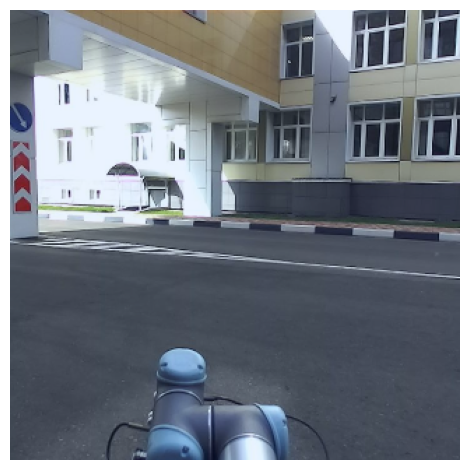

In [12]:
id_to_show = 1
ts.show(database_reader[id_to_show]["image_front_cam"])
print(f"Pose: {database_reader[id_to_show]['pose'].numpy()}")

## Инициализация модели


Сначала обычная модель для одиночных фреймов данных.

Здесь мы используем Bag-of-Queries (BoQ) с бэкбоном DINOv2.
О методе - https://github.com/amaralibey/Bag-of-Queries

In [13]:
model = BoQModel(backbone_name="dinov2")

Using cache found in /home/melekhin_aa/.cache/torch/hub/amaralibey_bag-of-queries_main
Using cache found in /home/melekhin_aa/.cache/torch/hub/facebookresearch_dinov2_main
/home/melekhin_aa/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/melekhin_aa/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/melekhin_aa/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
INFO:dinov2:using MLP layer as FFN


Модели в OPR ожидают определенный формат входных данных:
- `images_<camera_name>` - батч изображений для камеры `<camera_name>`


In [14]:
sample_frame = database_reader[id_to_show]
sample_output = model(sample_frame)

KeyError: "No key starting with 'images_' found in the batch."

**❗ Внимание:** `model.forward` ожидает на вход **батч** из словаря с ключами `images_<camera_name>` - размерность батча должна быть `(B, 3, H, W)`, где `B` - количество изображений в батче, `H` и `W` - высота и ширина изображений соответственно.

In [26]:
batch_size = 1
database_dl = torch.utils.data.DataLoader(
    database_reader,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=database_reader.collate_fn,
    drop_last=False,
)

sample_batch = next(iter(database_dl))
print(f"Batch sample keys: {sample_batch.keys()}")
print(f"Batch sample shapes: {[v.shape for v in sample_batch.values()]}")

Batch sample keys: dict_keys(['images_front_cam'])
Batch sample shapes: [torch.Size([1, 3, 322, 322])]


In [27]:
sample_output = model(sample_batch)

print(f"Sample output keys: {sample_output.keys()}")
print(f"Sample output shapes: {[v.shape for v in sample_output.values()]}")
print(f"Sample descriptor shape: {sample_output['final_descriptor'].shape}")

Sample output keys: dict_keys(['final_descriptor'])
Sample output shapes: [torch.Size([1, 12288])]
Sample descriptor shape: torch.Size([1, 12288])


## Подготовка БД

Для использования пайплайна инференса OPR необходимо подготовить базу данных в формате `faiss` индекса

In [18]:
batch_size = 16
database_dl = torch.utils.data.DataLoader(
    database_reader,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=database_reader.collate_fn,
    drop_last=False,
)

In [19]:
database_dir = DATA_DIR / "test" / "database"
database_dir.mkdir(parents=True, exist_ok=True)

model = model.to("cuda")
model.eval()

descriptors_list = []
with torch.no_grad():
    for batch in tqdm(database_dl):
        batch = {k: v.to("cuda") for k, v in batch.items()}
        descriptors = model(batch)["final_descriptor"]
        descriptors_list.append(descriptors)
descriptors = torch.cat(descriptors_list, dim=0)
print(f"Descriptors shape: {descriptors.shape}")

# Create L2 distance FAISS index for nearest neighbor search
faiss_index = faiss.IndexFlatL2(descriptors.shape[1])
faiss_index.add(descriptors.cpu().numpy())
faiss.write_index(
    faiss_index,
    str(database_dir / "index.faiss")
)

# Copy pose data as track.csv (required by PlaceRecognitionPipeline)
shutil.copy(DATA_DIR / "test" / "07_2023-10-04-day" / "track.csv", database_dir / "track.csv")

  0%|          | 0/29 [00:00<?, ?it/s]/home/melekhin_aa/Work/iprofihack2025_phystech_cartography/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 29/29 [00:09<00:00,  3.17it/s]


Descriptors shape: torch.Size([464, 12288])


PosixPath('/home/melekhin_aa/Work/iprofihack2025_phystech_cartography/data/test/database/track.csv')

## Sequence-based baseline

В качестве бейзлайна для обработки последовательностей предлагается использовать алгоритм **Candidate Pool Fusion**:

![candidate_pool_fusion](../images/candidate_pool_fusion.jpg)

См. код в `opr.pipelines.place_recognition.sequential`

## Чтение query данных

Для удобства напишем небольшой Wrapper, который будет читать несколько фреймов из исходного DataReader и возвращать их в виде последовательности

In [22]:
class TrackSeqWrapper:
    def __init__(self, track_data_reader: ITLPTrackDataReader, seq_len: int = 3):
        """Wrapper for ITLPTrackDataReader to provide sequences of specified length."""
        self.track_data_reader = track_data_reader
        self.seq_len = seq_len

    def __len__(self) -> int:
        return len(self.track_data_reader)

    def __getitem__(self, idx: int) -> list[dict[str, Tensor]]:
        """Get a sequence of frames up to the given index."""
        sequence = []
        for i in range(max(0, idx - self.seq_len + 1), idx + 1):
            sequence.append(self.track_data_reader[i])
        return sequence

In [23]:
query_reader = ITLPTrackDataReader(
    root=DATA_DIR / "test" / "08_2023-10-11-night",
    image_transform=setup_transforms(image_size=322),
)

seq_data_reader = TrackSeqWrapper(
    track_data_reader=query_reader,
    seq_len=3,
)

См. реализации в коде библиотеки OPR:
- `opr.models.place_recognition.sequential.SequenceLateFusionModel`
- `opr.modules.temporal.TemporalAveragePooling`


In [24]:
seq_model = SequenceLateFusionModel(
    model=model,
    temporal_fusion_module=TemporalAveragePooling()
)

pipe = SequencePlaceRecognitionPipeline(
    database_dir=DATA_DIR / "test" / "database",
    model=seq_model,
    use_candidate_pool_fusion=True,
)

In [25]:
output_ids = []
for query_seq in tqdm(seq_data_reader):
    output = pipe.infer(query_seq)
    output_ids.append(output['idx'])

with open(SUBMISSIONS_DIR / "baseline.txt", "w") as f:
    for idx in output_ids:
        f.write(f"{idx}\n")

print(f"Submissions saved to {SUBMISSIONS_DIR / 'baseline.txt'}")

100%|██████████| 505/505 [05:33<00:00,  1.52it/s]

Submissions saved to /home/melekhin_aa/Work/iprofihack2025_phystech_cartography/submissions/baseline.txt


## Визуализация результатов

WIP